In [67]:
import numpy as np
import matplotlib.pyplot as plt
from math import log

%matplotlib inline

In [68]:
dna = open('../data/Scaleup_counts_sequences/DNACOUNTS/ScaleUpDesign1_SV40P_Plasmid.counts')
rna1 = open('../data/Scaleup_counts_sequences/HEPG2/HepG2_ScaleUpDesign1_SV40P_mRNA_Rep1.counts')
rna2 = open('../data/Scaleup_counts_sequences/HEPG2/HepG2_ScaleUpDesign1_SV40P_mRNA_Rep2.counts')

rep1, rep2, dna_count = [], [], []
total_r_rep1, total_r_rep2, total_d = 0, 0, 0
for d, r1, r2 in zip(dna, rna1, rna2)[1:]:
    d_name, d_val   =  d.strip().split()
    r1_name, r1_val = r1.strip().split()
    r2_name, r2_val = r2.strip().split()
    assert d_name == r1_name == r2_name
    d_val, r1_val, r2_val = map(float, [d_val, r1_val, r2_val])
    rep1 += [log(r1_val + 1, 2) - log(d_val + 1, 2)]
    rep2 += [log(r2_val + 1, 2) - log(d_val + 1, 2)]
    dna_count += [d_val]
    
    total_r_rep1 += r1_val + 1
    total_r_rep2 += r2_val + 1
    total_d += d_val + 1
    
rep1 = map(lambda x: x + log(total_d, 2) - log(total_r_rep1, 2), rep1)
rep2 = map(lambda x: x + log(total_d, 2) - log(total_r_rep2, 2), rep2)
    
    


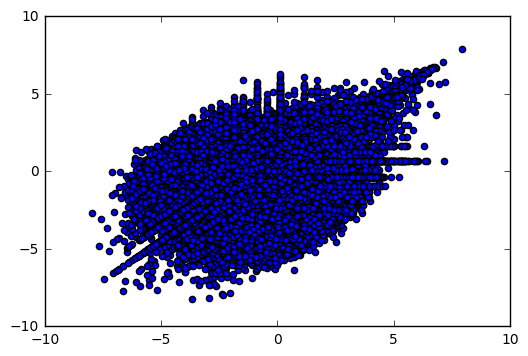

In [69]:
plt.scatter(rep1, rep2)
plt.show()

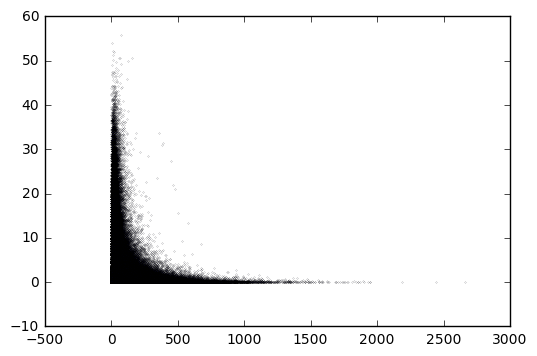

In [70]:
variance = [(r1 - r2)**2 for r1, r2 in zip(rep1, rep2)]
plt.scatter(dna_count, variance, s = .01)
plt.show()

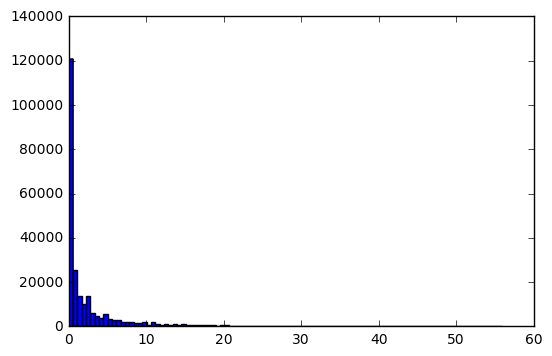

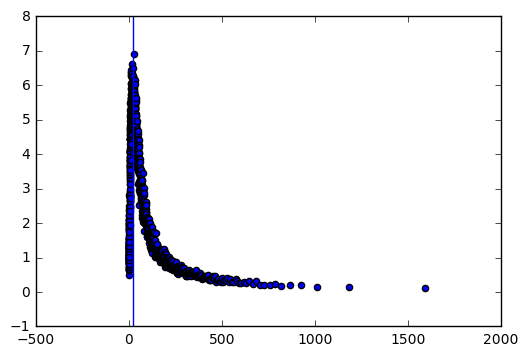

In [74]:
def quantile_plot(data_pairs, quantiles = 5000):
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [data_pairs[j][1] for j in index]
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    plt.scatter(avg_activity, avg_score)
    plt.axvline(20)
    plt.show()
    
quantile_plot(zip(dna_count, variance), 1000)